# Churn Predictive Analytics using Amazon SageMaker and Snowflake

---
## Background

The purpose of this lab is to demonstrate the basics of building an advanced analytics solution using Amazon SageMaker on data stored in Snowflake. In this notebook we will create a customer churn analytics solution by training an [Autogluon](https://github.com/awslabs/autogluon) churn model, and batching churn prediction scores back into Snowflake to power analytics. 

#### Learning Objectives 

 - Learn how to query ground truth data from Snowflake into a pandas dataframe for exploration and feature engineering.
 - Train an [AutoGluon](https://github.com/awslabs/autogluon) model to perform churn prediction.
 - Learn how to run a Batch Transform job to batch predictions.
 - Upload the Churn Score results back to Snowflake to perform basic analysis. 

---

## Prerequisites


In summary:
 - You've built the lab environment using this CloudFormation [template](https://snowflake-corp-se-workshop.s3-us-west-1.amazonaws.com/sagemaker-snowflake-devdays-v1.5/sagemaker/snowflake-sagemaker-notebook-v1.5.yaml). This template installs the Snowflake python connector within your Jupyter instance.
 - You've taken note of the Snowflake credentials in the lab guide.
 - This notebook should be running in your default VPC. 
 - Snowflake traffic uses port 443.
---

## Setup

First, let's import Python libraries required by this notebook.

We also obtain a reference to the IAM role attached to this notebook. This IAM role was created when you ran the CloudFormation Template. It provides you the permission to run the various SageMaker commands in this lab, and access data in your S3 bucket.

In practice, ensure your roles only provide minimum privileges.

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime

import sagemaker
from sagemaker import AlgorithmEstimator, get_execution_role
from sagemaker.predictor import RealTimePredictor, csv_serializer, StringDeserializer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sess = sagemaker.Session()
role = get_execution_role()
region = boto3.Session().region_name
print("IAM role ARN: {}".format(role))

IAM role ARN: arn:aws:iam::537234121179:role/service-role/snowflake-notebook-ExecutionRole-1ILKWFWIWCQ7C


---

Now let's set the S3 bucket and prefix that we'll be using for staging our data for training and batch inference. This bucket should be created within the same region as where you deployed your resources using the CloudFormation template. 

- Replace <<'REPLACE WITH YOUR BUCKET NAME'>> with the name of your bucket.
---

In [2]:
# Example: bucket = 'snowflake-sagemaker-workshop-your-accountid'
bucket = 'snowflake-sagemaker-workshop-537234121179'
prefix = 'churn-analytics-lab'

---
## Access our Data

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.  In the previous steps, this dataset was loaded into the CUSTOMER_CHURN table in your Snowflake instance.

Provide the connection and credentials required to connect to your Snowflake account. You'll need to modify the cell below with the appropriate **ACCOUNT** for your Snowflake trial. If you followed the lab guide instructions, the username and password below will work. 

>**NOTE:** For Snowflake accounts in regions **other than US WEST** add the Region ID after a period <ACCOUNT>.<REGION ID> i.e. XYZ123456.US-EAST-1.

In practice, security standards might prohibit you from providing credentials in clear text. As a best practice in production, you should utilize a service like [AWS Secrets Manager](https://docs.aws.amazon.com/secretsmanager/latest/userguide/intro.html) to manage your database credentials.

In [41]:
import snowflake.connector
# Connecting to Snowflake using the default authenticator
ctx = snowflake.connector.connect(
  user='sagemaker',
  password='AWSSF123',
  account='hs13221.US-EAST-2.aws',
  warehouse='SAGEMAKER_WH',
  database='ML_WORKSHOP',
  schema='PUBLIC'
)

---
## Data Exploration

Now we can query Snowflake from our SageMaker Notebook. 

In practice, the data table will often contain more data than what is practical to operate on within a notebook instance, or relevant attributes are spread across multiple tables. Being able to run SQL queries and loading the data into a pandas dataframe will be helpful during the initial stages of development. Check out the Spark integration for a fully scalable solution. [Snowflake Connector for Spark](https://docs.snowflake.net/manuals/user-guide/spark-connector.html)

---

In [17]:
# Query Snowflake Data
cs=ctx.cursor()
allrows=cs.execute("""select Cust_ID,STATE,ACCOUNT_LENGTH,AREA_CODE,PHONE,INTL_PLAN,VMAIL_PLAN,VMAIL_MESSAGE,
                   DAY_MINS,DAY_CALLS,DAY_CHARGE,EVE_MINS,EVE_CALLS,EVE_CHARGE,NIGHT_MINS,NIGHT_CALLS,
                   NIGHT_CHARGE,INTL_MINS,INTL_CALLS,INTL_CHARGE,CUSTSERV_CALLS,
                   CHURN from CUSTOMER_CHURN """).fetchall()

churn = pd.DataFrame(allrows)
churn.columns=['Cust_id','State','Account Length','Area Code','Phone','Intl Plan', 'VMail Plan', 'VMail Message','Day Mins',
            'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls','Night Charge',
            'Intl Mins','Intl Calls','Intl Charge','CustServ Calls', 'Churn']

pd.set_option('display.max_columns', 500)     # Make sure we can see all of the columns
pd.set_option('display.max_rows', 10)         # Keep the output on one page
churn

Cust_id State  Account Length  Area Code     Phone Intl Plan VMail Plan  \
0           1    KS             128        415  382-4657        no        yes   
1           2    OH             107        415  371-7191        no        yes   
2           3    NJ             137        415  358-1921        no         no   
3           4    OH              84        408  375-9999       yes         no   
4           5    MA             121        510  355-9993        no        yes   
...       ...   ...             ...        ...       ...       ...        ...   
3328     3329    OK             138        510  406-5532        no        yes   
3329     3330    AL              89        510  347-2016        no         no   
3330     3331    ND             131        408  393-9548        no        yes   
3331     3332    ND             122        408  395-1901        no         no   
3332     3333    OH             136        408  392-1547       yes         no   

      VMail Message  Day Mins  Day Calls  Day Charge  Eve Mins  Eve Calls  \
0                25     265.1        110       45.07     197.4         99   
1                26     161.6        123       27.47     195.5        103   
2                 0     243.4        114       41.38     121.2        110   
3                 0     299.4         71       50.90      61.9         88   
4                24     218.2         88       37.09     348.5        108   
...             ...       ...        ...         ...       ...        ...   
3328             33     155.2        139       26.38     268.3         79   
3329              0     129.2         71       21.96     214.1         68   
3330             33     177.1        100       30.11     194.0         85   
3331              0     231.2        141       39.30     267.8        136   
3332              0     183.4        103       31.18     141.9        113   

      Eve Charge  Night Mins  Night Calls  Night Charge  Intl Mins  \
0          16.78       244.7           91         11.01       10.0   
1          16.62       254.4          103         11.45       13.7   
2          10.30       162.6          104          7.32       12.2   
3           5.26       196.9           89          8.86        6.6   
4          29.62       212.6          118          9.57        7.5   
...          ...         ...          ...           ...        ...   
3328       22.81       186.4           71          8.39        9.7   
3329       18.20       214.9          100          9.67       10.3   
3330       16.49       253.4          124         11.40        5.2   
3331       22.76       240.3          100         10.81        8.8   
3332       12.06       200.4          122          9.02       10.4   

      Intl Calls  Intl Charge  CustServ Calls   Churn  
0              3         2.70               1  False.  
1              3         3.70               1  False.  
2              5         3.29               0  False.  
3              7         1.78               2  False.  
4              7         2.03               3  False.  
...          ...          ...             ...     ...  
3328           4         2.62               3  False.  
3329           4         2.78               5   True.  
3330           5         1.40               1  False.  
3331           5         2.38               1   True.  
3332           9         2.81               2  False.  

[3333 rows x 22 columns]

---

By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn`: whether the customer left the service: true/false

The last attribute, `Churn`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

---

col_0  % observations
State                
AK           0.015602
AL           0.024002
AR           0.016502
AZ           0.019202
CA           0.010201
...               ...
VT           0.021902
WA           0.019802
WI           0.023402
WV           0.031803
WY           0.023102

[51 rows x 1 columns]

col_0     % observations
Phone                   
327-1058          0.0003
327-1319          0.0003
327-3053          0.0003
327-3587          0.0003
327-3850          0.0003
...                  ...
422-7728          0.0003
422-8268          0.0003
422-8333          0.0003
422-8344          0.0003
422-9964          0.0003

[3333 rows x 1 columns]

col_0      % observations
Intl Plan                
no                0.90309
yes               0.09691

col_0       % observations
VMail Plan                
no                0.723372
yes               0.276628

col_0   % observations
Churn                 
False.        0.855086
True.         0.144914

Cust_id  Account Length    Area Code  VMail Message     Day Mins  \
count  3333.00000     3333.000000  3333.000000    3333.000000  3333.000000   
mean   1667.00000      101.064806   437.182418       8.099010   179.775098   
std     962.29855       39.822106    42.371290      13.688365    54.467389   
min       1.00000        1.000000   408.000000       0.000000     0.000000   
25%     834.00000       74.000000   408.000000       0.000000   143.700000   
50%    1667.00000      101.000000   415.000000       0.000000   179.400000   
75%    2500.00000      127.000000   510.000000      20.000000   216.400000   
max    3333.00000      243.000000   510.000000      51.000000   350.800000   

         Day Calls   Day Charge     Eve Mins    Eve Calls   Eve Charge  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.435644    30.562307   200.980348   100.114311    17.083540   
std      20.069084     9.259435    50.713844    19.922625     4.310668   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      87.000000    24.430000   166.600000    87.000000    14.160000   
50%     101.000000    30.500000   201.400000   100.000000    17.120000   
75%     114.000000    36.790000   235.300000   114.000000    20.000000   
max     165.000000    59.640000   363.700000   170.000000    30.910000   

        Night Mins  Night Calls  Night Charge    Intl Mins   Intl Calls  \
count  3333.000000  3333.000000   3333.000000  3333.000000  3333.000000   
mean    200.872037   100.107711      9.039325    10.237294     4.479448   
std      50.573847    19.568609      2.275873     2.791840     2.461214   
min      23.200000    33.000000      1.040000     0.000000     0.000000   
25%     167.000000    87.000000      7.520000     8.500000     3.000000   
50%     201.200000   100.000000      9.050000    10.300000     4.000000   
75%     235.300000   113.000000     10.590000    12.100000     6.000000   
max     395.000000   175.000000     17.770000    20.000000    20.000000   

       Intl Charge  CustServ Calls  
count  3333.000000     3333.000000  
mean      2.764581        1.562856  
std       0.753773        1.315491  
min       0.000000        0.000000  
25%       2.300000        1.000000  
50%       2.780000        1.000000  
75%       3.270000        2.000000  
max       5.400000        9.000000

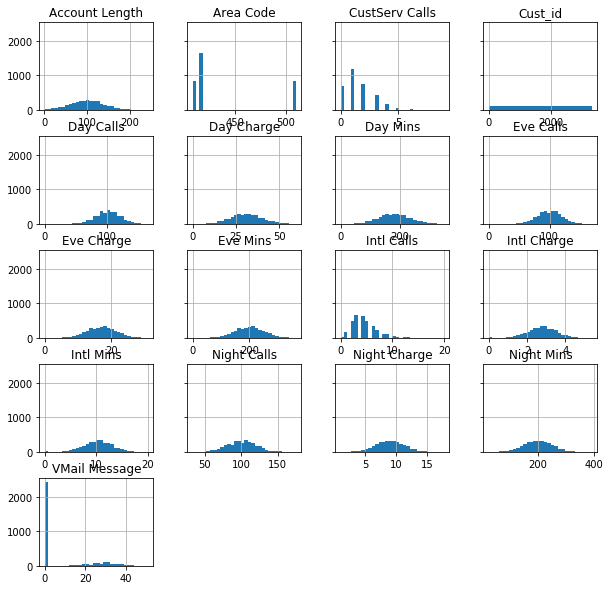

In [18]:
# Frequency tables for each categorical feature
for column in churn.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=churn[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(churn.describe())
%matplotlib inline
hist = churn.hist(bins=30, sharey=True, figsize=(10, 10))

---

We can see immediately that:
- `State` appears to be quite evenly distributed
- `Phone` takes on too many unique values to be of any practical use.  It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.
- Only 14% of customers churned, so there is some class imabalance, but nothing extreme.
- Most of the numeric features are surprisingly nicely distributed, with many showing bell-like gaussianity.  `VMail Message` being a notable exception (and `Area Code` showing up as a feature we should convert to non-numeric).

---

In [19]:
churn = churn.drop('Phone', axis=1)
churn['Area Code'] = churn['Area Code'].astype(object)

---

Next, let's look at the relationship between each of the features and our target variable.

---

Churn    False.     True.
State                    
AK     0.017193  0.006211
AL     0.025263  0.016563
AR     0.015439  0.022774
AZ     0.021053  0.008282
CA     0.008772  0.018634
...         ...       ...
VT     0.022807  0.016563
WA     0.018246  0.028986
WI     0.024912  0.014493
WV     0.033684  0.020704
WY     0.023860  0.018634

[51 rows x 2 columns]

Churn        False.     True.
Area Code                    
408        0.251228  0.252588
415        0.497895  0.488613
510        0.250877  0.258799

Churn        False.     True.
Intl Plan                    
no         0.934737  0.716356
yes        0.065263  0.283644

Churn         False.     True.
VMail Plan                    
no          0.704561  0.834369
yes         0.295439  0.165631

Cust_id


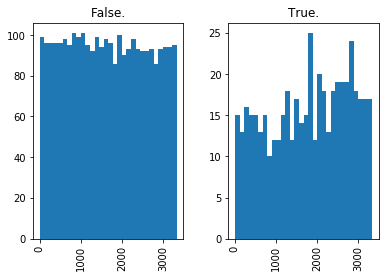

Account Length


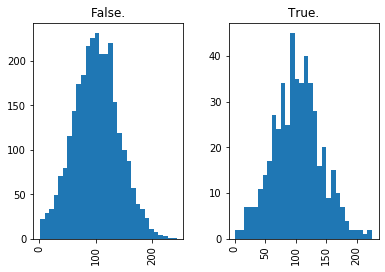

VMail Message


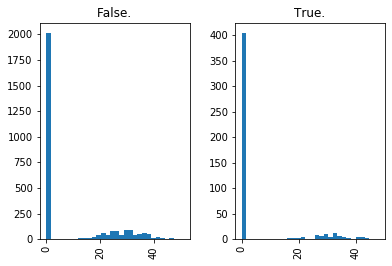

Day Mins


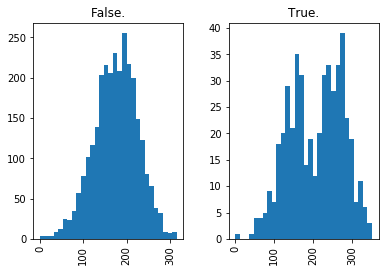

Day Calls


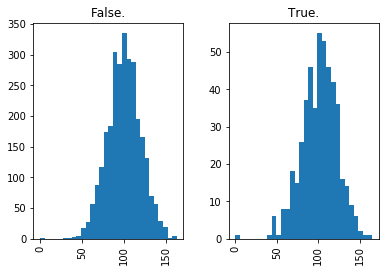

Day Charge


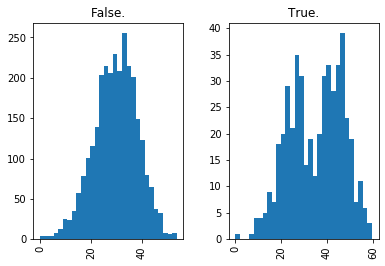

Eve Mins


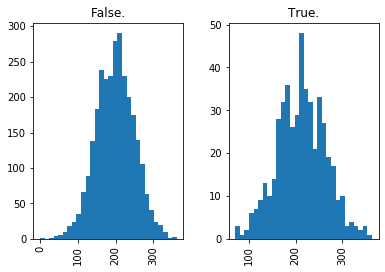

Eve Calls


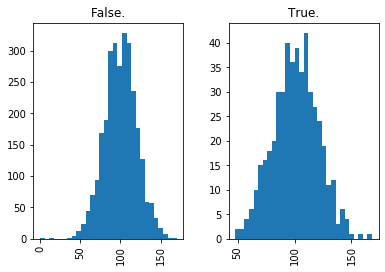

Eve Charge


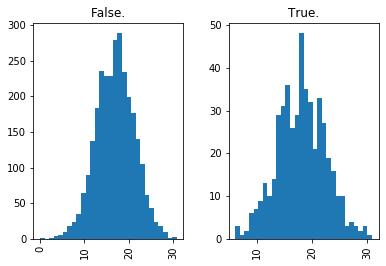

Night Mins


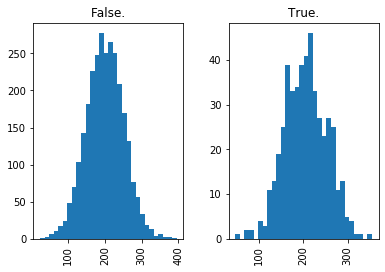

Night Calls


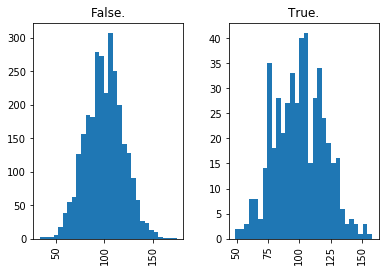

Night Charge


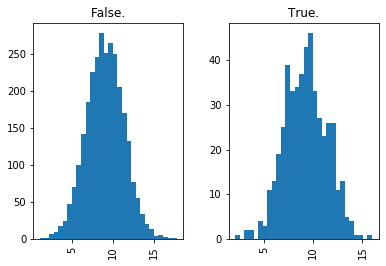

Intl Mins


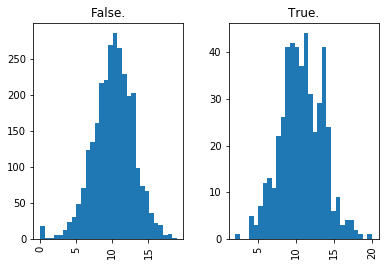

Intl Calls


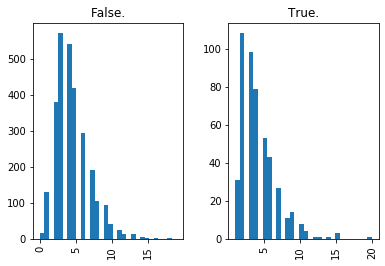

Intl Charge


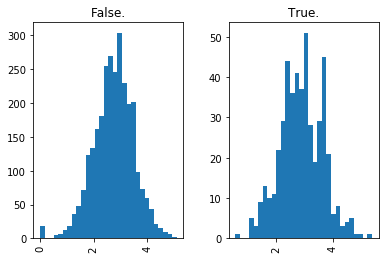

CustServ Calls


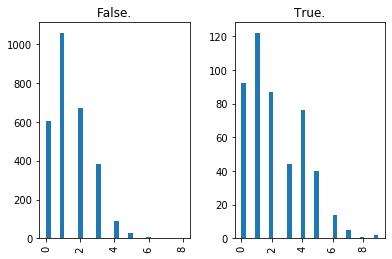

In [20]:
for column in churn.select_dtypes(include=['object']).columns:
    if column != 'Churn':
        display(pd.crosstab(index=churn[column], columns=churn['Churn'], normalize='columns'))

for column in churn.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = churn[[column, 'Churn']].hist(by='Churn', bins=30)
    plt.show()

---

Interestingly we see that churners appear:
- Fairly evenly distributed geographically
- More likely to have an international plan
- Less likely to have a voicemail plan
- To exhibit some bimodality in daily minutes (either higher or lower than the average for non-churners)
- To have a larger number of customer service calls (which makes sense as we'd expect customers who experience lots of problems may be more likely to churn)

In addition, we see that churners take on very similar distributions for features like `Day Mins` and `Day Charge`.  That's not surprising as we'd expect minutes spent talking to correlate with charges.  Let's dig deeper into the relationships between our features.

---

Cust_id  Account Length  VMail Message  Day Mins  Day Calls  \
Cust_id         1.000000        0.038367      -0.022238 -0.022226  -0.004176   
Account Length  0.038367        1.000000      -0.004628  0.006216   0.038470   
VMail Message  -0.022238       -0.004628       1.000000  0.000778  -0.009548   
Day Mins       -0.022226        0.006216       0.000778  1.000000   0.006750   
Day Calls      -0.004176        0.038470      -0.009548  0.006750   1.000000   
...                  ...             ...            ...       ...        ...   
Night Charge    0.015671       -0.008960       0.007663  0.004300   0.022927   
Intl Mins       0.003058        0.009514       0.002856 -0.010155   0.021565   
Intl Calls     -0.014506        0.020661       0.013957  0.008033   0.004574   
Intl Charge     0.002994        0.009546       0.002884 -0.010092   0.021666   
CustServ Calls  0.014692       -0.003796      -0.013263 -0.013423  -0.018942   

                Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins  \
Cust_id          -0.022226  0.021881   0.013597    0.021889    0.015647   
Account Length    0.006214 -0.006757   0.019260   -0.006745   -0.008955   
VMail Message     0.000776  0.017562  -0.005864    0.017578    0.007681   
Day Mins          1.000000  0.007043   0.015769    0.007029    0.004323   
Day Calls         0.006753 -0.021451   0.006462   -0.021449    0.022938   
...                    ...       ...        ...         ...         ...   
Night Charge      0.004301 -0.012593  -0.002056   -0.012601    0.999999   
Intl Mins        -0.010157 -0.011035   0.008703   -0.011043   -0.015207   
Intl Calls        0.008032  0.002541   0.017434    0.002541   -0.012353   
Intl Charge      -0.010094 -0.011067   0.008674   -0.011074   -0.015180   
CustServ Calls   -0.013427 -0.012985   0.002423   -0.012987   -0.009288   

                Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
Cust_id           -0.002931      0.015671   0.003058   -0.014506     0.002994   
Account Length    -0.013176     -0.008960   0.009514    0.020661     0.009546   
VMail Message      0.007123      0.007663   0.002856    0.013957     0.002884   
Day Mins           0.022972      0.004300  -0.010155    0.008033    -0.010092   
Day Calls         -0.019557      0.022927   0.021565    0.004574     0.021666   
...                     ...           ...        ...         ...          ...   
Night Charge       0.011188      1.000000  -0.015214   -0.012329    -0.015186   
Intl Mins         -0.013605     -0.015214   1.000000    0.032304     0.999993   
Intl Calls         0.000305     -0.012329   0.032304    1.000000     0.032372   
Intl Charge       -0.013630     -0.015186   0.999993    0.032372     1.000000   
CustServ Calls    -0.012802     -0.009277  -0.009640   -0.017561    -0.009675   

                CustServ Calls  
Cust_id               0.014692  
Account Length       -0.003796  
VMail Message        -0.013263  
Day Mins             -0.013423  
Day Calls            -0.018942  
...                        ...  
Night Charge         -0.009277  
Intl Mins            -0.009640  
Intl Calls           -0.017561  
Intl Charge          -0.009675  
CustServ Calls        1.000000  

[16 rows x 16 columns]

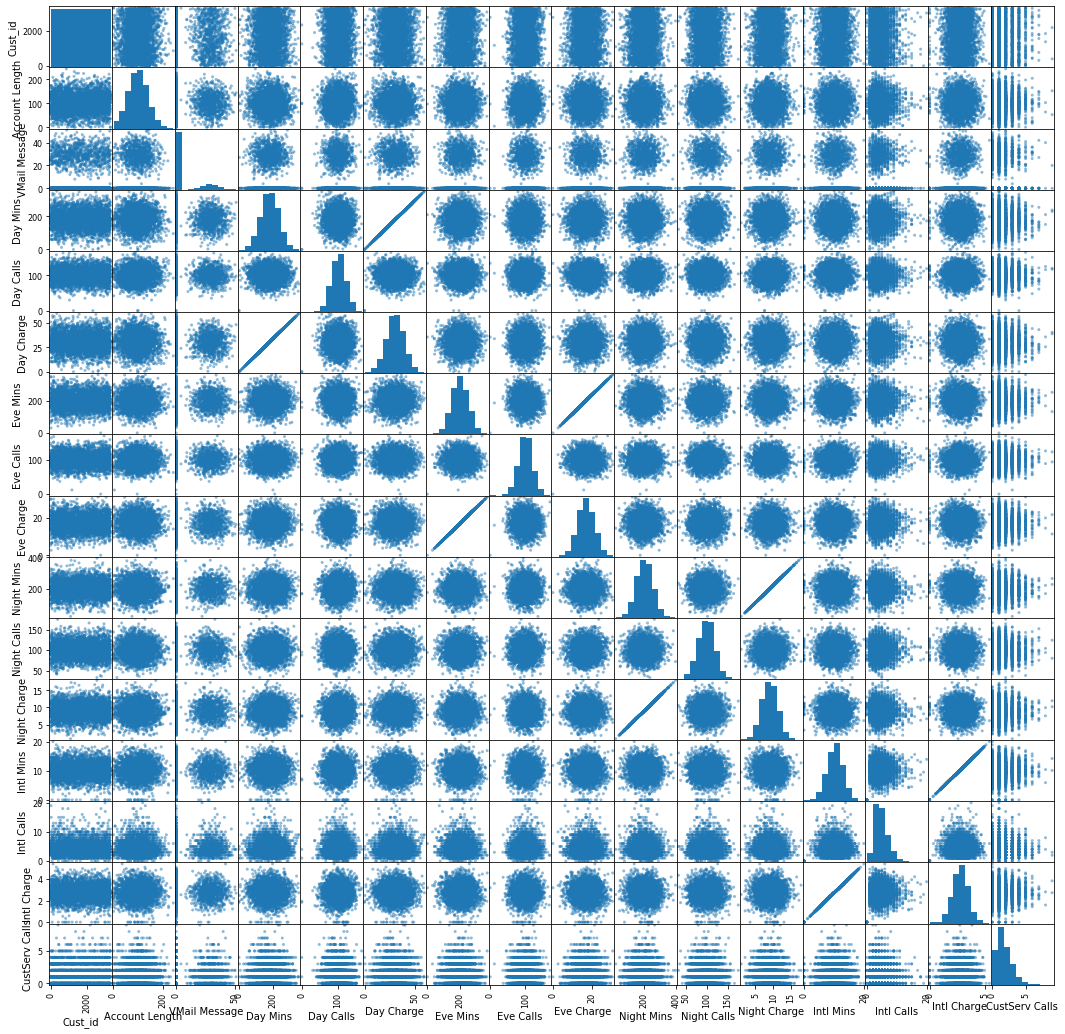

In [21]:
display(churn.corr())
pd.plotting.scatter_matrix(churn, figsize=(18, 18))
plt.show()

---

We see several features that essentially have 100% correlation with one another.  Including these feature pairs in some machine learning algorithms can create catastrophic problems, while in others it will only introduce minor redundancy and bias.  Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

---

In [22]:
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

---

## Automate Feature Engineering using AutoML


Our data is now prep for ML. Normally, we would experiment with potential algorithms and performing additional feature engineering tasks to craft features with potentially stronger signals.

We're going to shortcut this process of using one of our Tabular AutoML options: AutoGluon. AutoGluon is an toolkit created by AWS Labs. Information about the contributors and the research work is documented in this [paper](https://arxiv.org/pdf/2003.06505.pdf).

Amazon SageMaker provides easy ways to train and deploy MXNet/Gluon based models simply by bringing your own script. AutoGluon is also conveniently packaged as a Marketplace [product](https://aws.amazon.com/marketplace/pp/prodview-n4zf5pmjt7ism) for SageMaker, so we don't need to worry about the operational heavy-lifting involved in maintaining containers and the runtime environments. We're going to use this product today in our workshop.

SageMaker provides other Tabular AutoML options via [Autopilot](https://aws.amazon.com/sagemaker/autopilot/). There are trade-offs between options. For this small dataset, AutoGluon runs much faster and produces great results. Autopilot runs distributed and the overhead is prohibitive for the purpose of this workshop. However, the serverless  and native distributed setup is more practical for larger datasets, and is easier to manage. 

Tabular AutoML automates the experimentation process of automating data analysis, feature engineering, exploring candidate algorithms and pipelines, hyperparameter tuning and ensemble generation. This potentially enables non-ML-experts to produce high-quality ML models.

---

## Finalize our Datasets

And now let's split the data into training and test sets.  This will help prevent overfitting, and allow us to test the models accuracy on unseen data. 

Traditionally, you would create a third validation set, which would be used during training. The validation set would be used in each training epoch to evaluate progress and help monitor overfitting issues. AutoGluon creates the validation set for us automatically.

---

In [23]:
to_split_data = churn.drop(['Cust_id'], axis=1)
train_data, test_data = np.split(to_split_data.sample(frac=1, random_state=1729), [int(0.9 * len(to_split_data))])
train_data.to_csv('train.csv', header=True, index=False)

---

Let's preview our training set. Looks like a normal database table! AutoGluon will automatically profile your dataset and identify the prescence of catagorical attributes like *State* and apply appropriate transformations like *one-hot-encoding*.

---

In [24]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
display(train_data)

State  Account Length Area Code Intl Plan VMail Plan  VMail Message  Day Mins  Day Calls  Eve Mins  Eve Calls  Night Mins  Night Calls  Intl Mins  Intl Calls  CustServ Calls   Churn
1095    MT             116       415        no        yes             35     182.8        122     212.7        119       193.8          103       11.0           2               1  False.
608     ID             144       415        no        yes             33     251.6         87     197.6        118       209.2           97       12.2           3               2  False.
2908    TN               3       415        no         no              0     185.0        120     203.7        129       170.5           89       14.1           3               3  False.
943     OH              56       408        no         no              0      91.1         90     179.3        115       300.7           89       11.9           8               2  False.
693     AL             144       415        no         no              0     177.5         93     287.4         75       180.5          118       11.9           3               2  False.
...    ...             ...       ...       ...        ...            ...       ...        ...       ...        ...         ...          ...        ...         ...             ...     ...
1655    IL              89       415       yes        yes             19     112.6        114     261.7        132       123.5          116       11.1           2               0   True.
666     AZ              90       415        no         no              0     179.2         77     210.7         99       276.9           58        9.2           6               2  False.
2100    NE              61       408        no         no              0     267.1        104     180.4        131       230.6          106       17.3           4               1   True.
1511    CT             163       408        no        yes             40     231.9         56     211.8         91       268.5           74       12.3           3               2  False.
2608    AL             136       510        no         no              0     109.4         91     207.5        111       135.0          107       11.6           5               0  False.

[2999 rows x 16 columns]

---

SageMaker training ingests training data from S3, so we'll need to stage our datasets in our S3 bucket.

---

In [25]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')

---
## Subscribe to AutoGluon in the AWS Marketplace

1. **Follow [this URL](https://aws.amazon.com/marketplace/pp/Amazon-Web-Services-AutoGluon-Tabular/prodview-n4zf5pmjt7ism) to the AutoGluon-Tabular product page.**
2. Select the orange "Continue to Subscribe" button.
3. Run the helper function below to identify the AWS resource ID (ARN) of your AutoGluon Marketplace algorithm.

---

In [26]:
AUTOGLUON_PRODUCT = "autogluon-tabular-v2-a11d018f6028f8192e60553704ee3d97"
def get_algorithm_arn(region, algo_name):
    acct_mapping = {
        "ap-northeast-1" : "977537786026",
        "ap-northeast-2" : "745090734665",
        "ap-southeast-1" : "192199979996",
        "ap-southeast-2" : "666831318237",
        "us-east-1"      : "865070037744",
        "eu-central-1"   : "446921602837",
        "ap-south-1"     : "077584701553",
        "sa-east-1"      : "270155090741",
        "ca-central-1"   : "470592106596",
        "eu-west-1"      : "985815980388",
        "eu-west-2"      : "856760150666",
        "eu-west-3"      : "843114510376",
        "eu-north-1"     : "136758871317",
        "us-west-1"      : "382657785993",
        "us-east-2"      : "057799348421",
        "us-west-2"      : "594846645681"
    }
        
    return "arn:aws:sagemaker:{}:{}:algorithm/{}".format(region, acct_mapping[region], algo_name)
    
algorithm_arn = get_algorithm_arn(boto3.Session().region_name, AUTOGLUON_PRODUCT)
print("The Tabular AutoGluon ARN in your region is {}.".format(algorithm_arn))

The Tabular AutoGluon ARN in your region is arn:aws:sagemaker:us-east-2:057799348421:algorithm/autogluon-tabular-v2-a11d018f6028f8192e60553704ee3d97.


---
## Model Training

Subscribing to the AutoGluon Marketplace algorithm provides you access to a SageMaker compatible container for the AutoGluon algorithm. This Marketplace algorithm is managed by AWS and doesn't have additonal software costs.

Once subscribed, Marketplace algorithms are similar to SageMaker built-in algorithms. These algorithms can be trained and deployed with "low-to-no-code". 

---

Next, we'll configure our algorithm for remote training (Note: you can configure and launch the job using the AWS console as an alternative to the SDK).

1. **Hyperparamters**: AutoML algorithms like AutoGluon are designed to automate hyperparameter tuning using hyperparamter search algorithms like Bayesian Optimization. Thus, setting hyperparameters are optional. However, you can override the defaults. We'll use the default configurations in this lab, so we only need to identify the name of the target label column. The other configurations are commented out and serve as examples.

2. **Infrastructure**: We're using SageMaker's remote training service, so we need to specify the infrastructure to allocate. Since we're using a Marketplace product, we need to be aware of the subset of supported instances. 

3. **Data**: lastly, we need to identify the location of our training data.

In [ ]:
sagemaker.s3

In [28]:
prefix

'churn-analytics-lab'

In [29]:
bucket

'snowflake-sagemaker-workshop-537234121179'

In [31]:
hyperparameters = {
    #"hyperparameters": {
    #    "NN":{"num_epochs": "1"}
    #},
    #"auto_stack": "True",
    "label": "Churn"
}

compatible_training_instance_type='ml.m5.4xlarge' 
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')

In [32]:
s3_input_train


---
Now, we create an Estimator object which describes our training job: security settings, infrastructure, data, and algorithms.

Executing the fit() method results in an API call to the SageMaker service to build your training cluster and execute the training job.

---

In [34]:
autogluon = AlgorithmEstimator(algorithm_arn=algorithm_arn, 
                                  role=role, 
                                  instance_count=1, 
                                  instance_type=compatible_training_instance_type, 
                                  sagemaker_session=sess, 
                                  base_job_name='autogluon',
                                  hyperparameters=hyperparameters,
                                  train_volume_size=100) 

autogluon.fit({'training': s3_input_train})

2020-12-03 01:53:42 Starting - Starting the training job...
2020-12-03 01:53:44 Starting - Launching requested ML instances......
2020-12-03 01:55:04 Starting - Preparing the instances for training...
2020-12-03 01:55:39 Downloading - Downloading input data
2020-12-03 01:55:39 Training - Downloading the training image......
2020-12-03 01:56:39 Training - Training image download completed. Training in progress..2020-12-03 01:56:40,461 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2020-12-03 01:56:40,462 sagemaker-containers INFO     Failed to parse hyperparameter hyperparameter_tune value False to Json.
Returning the value itself
2020-12-03 01:56:40,462 sagemaker-containers INFO     Failed to parse hyperparameter eval_metric value None to Json.
Returning the value itself
2020-12-03 01:56:40,462 sagemaker-containers INFO     Failed to parse hyperparameter auto_stack value False to Json.
Returning the value itself
2020-12-03 01:56:40,463 sagemaker-con

---

## Batch Inference

At last, we're ready to make predictions. We're going to do so through a batch process and evaluate it's performance against our labels. We'll use Batch Transform to create churn scores which score the likelihood that our customers will churn.

First, we upload the data we plan to use as batch input to S3. SageMaker Batch Transform is designed to run asynchronously and ingest input data from S3. This differs from SageMaker's real-time inference endpoints, which receive input data from synchronous HTTP requests.

For large scale deployments the data set will be retrieved from Snowflake using SQL and an External Stage to S3.

Batch Transform is often the ideal option for advanced analytics use case for several reasons:

 - Batch Transform is better optimized for throughput in comparison with real-time inference endpoints. Thus, Batch Transform is ideal for processing large volumes of data for analytics.
 - Offline asynchronous processing is acceptable for most analytics use cases.
 - Batch Transform is more cost efficient when real-time inference isn't necessary. You only need to pay for resources used during batch processing. There is no need to pay for ongoing resources like a hosted endpoint for real-time inference.
 
 ---

In [35]:
batch_input = churn.iloc[:,:-1]
batch_input.to_csv('batch.csv', header=False, index=False)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'batch/in/batch.csv')).upload_file('batch.csv')

s3uri_batch_input ='s3://{}/{}/batch/in'.format(bucket, prefix)
print('Batch Transform input S3 uri: {}'.format(s3uri_batch_input))

s3uri_batch_output= 's3://{}/{}/batch/out'.format(bucket, prefix)
print('Batch Transform output S3 uri: {}'.format(s3uri_batch_output))

Batch Transform input S3 uri: s3://snowflake-sagemaker-workshop-537234121179/churn-analytics-lab/batch/in
Batch Transform output S3 uri: s3://snowflake-sagemaker-workshop-537234121179/churn-analytics-lab/batch/out


---

Now we create a transformer() object to describe our batch job. The transform() call results in an API call to the SageMaker service to create and run the batch process.

---

In [36]:
from sagemaker.transformer import Transformer
BATCH_INSTANCE_TYPE = 'ml.c5.xlarge'

transformer = autogluon.transformer(instance_count=1,
                                         strategy='SingleRecord',
                                         assemble_with='Line',
                                         instance_type= BATCH_INSTANCE_TYPE,
                                         accept = 'text/csv',
                                         output_path=s3uri_batch_output)
    
transformer.transform(s3uri_batch_input,
                      split_type= 'Line',
                      content_type= 'text/csv',   
                      input_filter = "$[1:]",
                      join_source = "Input",
                      output_filter = "$[0,-1]")

..........
......................2020-12-03 02:11:09,697 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.6/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 4
Max heap size: 649 M
Python executable: /usr/local/bin/python3.6
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: /logs
Metrics dir: /logs
2020-12-03 02:11:09,697 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.6/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 4
Max heap size: 649 M
Python executable: /usr/local/bin/python3.6
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: /l

---

Batch transform jobs run asynchronously, and are non-blocking by default. Run the command below to block until the batch job completes.

---

In [37]:
transformer.wait()

2020-12-03 02:11:09,697 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.6/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 4
Max heap size: 649 M
Python executable: /usr/local/bin/python3.6
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: /logs
Metrics dir: /logs
2020-12-03 02:11:09,697 [INFO ] main com.amazonaws.ml.mms.ModelServer - 
MMS Home: /usr/local/lib/python3.6/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Number of GPUs: 0
Number of CPUs: 4
Max heap size: 649 M
Python executable: /usr/local/bin/python3.6
Config file: /etc/sagemaker-mms.properties
Inference address: http://0.0.0.0:8080
Management address: http://0.0.0.0:8080
Model Store: /.sagemaker/mms/models
Initial Models: ALL
Log dir: /logs
Metrics dir: /logs
Netty thre

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



---

There are many ways to compare the performance of a machine learning model, but let's start by simply by comparing actual to predicted values.  In this case, we're simply predicting whether the customer churned (`1`) or not (`0`), which produces a simple confusion matrix.

---

In [38]:
batched_churn_scores = pd.read_csv(s3uri_batch_output+'/batch.csv.out', usecols=[0,1], names=['id','scores'])
batched_churn_scores['scores'] = (batched_churn_scores['scores'] == "True.").astype(int)
#batched_churn_scores['Churn'] = (churn['Churn'] == "True.").astype(int)
gt_df = pd.DataFrame((churn['Churn'] == "True.").astype(int)).reset_index(drop=True)

results_df= pd.concat([gt_df,batched_churn_scores],axis=1)
pd.crosstab(index=results_df['Churn'], columns=np.round(results_df['scores']), rownames=['actual'], colnames=['predictions'])

predictions     0    1
actual                
0            2848    2
1              66  417

---

## Upload Churn Score to Snowflake

To be able to allow multiple business users and dashboards simple access to the churn scores we will upload it to Snowflake by using a Snowflake internal stage. 

---

In [45]:
from snowflake.connector.pandas_tools import write_pandas

#Set the column names of the dataframe to match the table column names
results_df.columns = ['CHURN_IN','CUST_ID','CHURN_SCORE']

# Write the predictions to the table named "ML_RESULTS".
success, nchunks, nrows, _ = write_pandas(ctx, results_df, 'ML_RESULTS')

display(nrows)


3333